## Business Validation – Optimisation du Seuil de Décision

### Objectif
Dans un contexte bancaire, l’objectif n’est pas de maximiser une métrique statistique
(AUC, Accuracy), mais de **maximiser le profit financier attendu** du portefeuille de crédits.

Ce notebook vise à :
- Définir une fonction de coût métier
- Tester différents seuils de décision
- Identifier le seuil optimal
- Comparer ce seuil au seuil standard de 0.5


In [1]:
import numpy as np
import pandas as pd
from joblib import load
import joblib
import matplotlib.pyplot as plt

In [2]:
model = load("../data/models/final_model_lgbm.pkl")
preprocessor = load("../data/models/preprocessor.pkl")

X_train, X_test, y_train, y_test = load(
    "../data/models/train_test_split.pkl"
)

In [3]:
X_test_processed = preprocessor.transform(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

c:\Users\GENERAL STORES-SARL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [4]:
LOAN_AMOUNT = 5_000_000       # XAF
INTEREST_RATE = 0.12         # 12%

In [5]:
def compute_profit(y_true, y_proba, threshold):
    """
    Calcule le profit total attendu pour un seuil donné
    """
    total_profit = 0

    for true, proba in zip(y_true, y_proba):
        decision = 1 if proba >= threshold else 0  # 1 = refus, 0 = accord

        if decision == 0 and true == 0:
            # Vrai négatif : client sain accordé
            total_profit += LOAN_AMOUNT * INTEREST_RATE

        elif decision == 0 and true == 1:
            # Faux négatif : défaut accordé (pire cas)
            total_profit -= LOAN_AMOUNT

        # Refus → impact nul (0)

    return total_profit

In [6]:
thresholds = np.linspace(0, 1, 101)
profits = []

for t in thresholds:
    profit = compute_profit(y_test.values, y_proba, t)
    profits.append(profit)


In [7]:
optimal_threshold = thresholds[np.argmax(profits)]
optimal_profit = max(profits)

standard_profit = compute_profit(y_test.values, y_proba, 0.5)

optimal_threshold, optimal_profit, standard_profit

(np.float64(0.29), 1840200000.0, 1492000000.0)

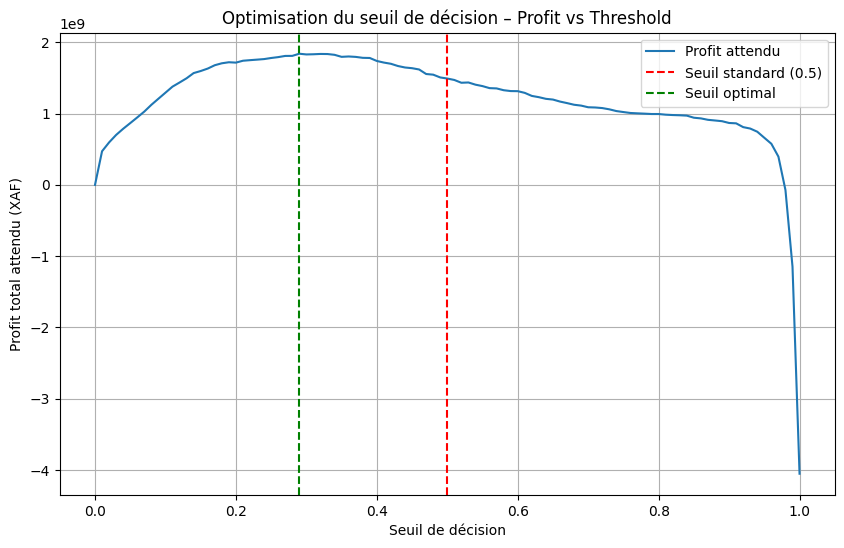

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, label="Profit attendu")
plt.axvline(0.5, color="red", linestyle="--", label="Seuil standard (0.5)")
plt.axvline(optimal_threshold, color="green", linestyle="--", label="Seuil optimal")
plt.xlabel("Seuil de décision")
plt.ylabel("Profit total attendu (XAF)")
plt.title("Optimisation du seuil de décision – Profit vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

## Conclusion Business

- Le seuil standard de 0.5 génère un profit de : **{standard_profit:,.0f} XAF**
- Le seuil optimal identifié est : **{optimal_threshold:.2f}**
- Ce seuil génère un profit de : **{optimal_profit:,.0f} XAF**

👉 L'utilisation du seuil optimisé permet d'améliorer la rentabilité du portefeuille
sans modifier le modèle de scoring.


In [9]:
import json

risk_config = {
    "optimal_threshold": float(optimal_threshold),
    "loan_amount": LOAN_AMOUNT,
    "interest_rate": INTEREST_RATE
}

with open("../data/models/risk_config.json", "w") as f:
    json.dump(risk_config, f, indent=4)
